<a href="https://colab.research.google.com/github/kuheli31/Fake-News-Detector/blob/main/Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [167]:
# 1️⃣ Install the base PyTorch (skip if already installed)
!pip install torch torchvision torchaudio --upgrade

# 2️⃣ Install PyTorch Geometric and its dependencies
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.3.0+cpu.html


  Using cached torch-2.9.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached torchvision-0.24.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
  Using cached torchaudio-2.9.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (6.9 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_cupti_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cublas_cu12-12.8.4.1-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cufft_cu12-11.3.3.83-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_curand_cu12-10.3.9.90-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cusolver_cu12-11.7.3.90-py3-none-manylinux_2_2

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cpu.html


In [2]:
import torch_geometric
print("PyTorch Geometric version:", torch_geometric.__version__)


/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cpu.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_cluster/_version_cpu.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_spline_conv/_version_cpu.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue oc

PyTorch Geometric version: 2.7.0


In [39]:
!pip install streamlit pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 62.6 MB/s eta 0:00:00


In [40]:
from pyngrok import ngrok

# Paste your ngrok token here (only first time)
!ngrok authtoken "35738Se3xKlAVdp1ymk7m94f7Mz_89N1LohxzQhm29kadhDPF"


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [3]:
from torch_geometric.data import Data


In [4]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import re
import string
import requests
from requests.utils import quote
from urllib.parse import quote

# Enter the news to verify if its real or fake

In [5]:
import spacy

# Load SpaCy model for keyword extraction
nlp = spacy.load("en_core_web_sm")

# Step 1: Get news input
news = input("Enter the news to verify if it is real or fake: ")

# Step 2: Process the text
doc = nlp(news)

# Step 3: Extract potential keywords — proper nouns or nouns that matter
keywords = [token.text for token in doc if token.pos_ in ["PROPN", "NOUN"] and len(token.text) > 2]

# Step 4: Remove duplicates while preserving order
seen = set()
keywords = [k for k in keywords if not (k.lower() in seen or seen.add(k.lower()))]

# Step 5: Keep only top 4 most important words (based on position and relevance)
news_check = keywords[:4]

print("Extracted Keywords for Search:", " ".join(news_check))


Enter the news to verify if it is real or fake: India poised to play key role at G20 Summit in Johannesburg - New Delhi, Nov 2 India, as the world's fastest-growing major economy, is poised to play a key role ... Get Latest News on Business only on lokmattimes.com Extracted Keywords for Search: India role G20 Summit
Extracted Keywords for Search: India role G20 Summit


# Data Collection

**G-News API (*Real News*)**

In [6]:
#Real time news api (https://gnews.io/dashboard) -- 100 requests per day
news_api_key = 'd2b27a1e3f818564545508b6c744d24a'
#Endpoints are -> {search , top-headlines}
endpoint = 'search'
#Parameters are -> {The topic the user want to search}
question = " ".join(news_check)
parameters = f'q={quote(question)}&lang=en&max=5'
#Example (try this link to understand the url)-> https://gnews.io/api/v4/top-headlines?q=modi&lang=en&max=5&apikey=d2b27a1e3f818564545508b6c744d24a
news_api_url = f'https://gnews.io/api/v4/{endpoint}?{parameters}&apikey={news_api_key}'

response = requests.get(news_api_url)
data = response.json()

if 'articles' in data:
    for article in data['articles']:
        print(f"Published Time: {article['publishedAt']}")
        print(f"Title: {article['title']}")
        print(f"Description: {article['description']}")
        print(f"Image: {article['image']}")
        print(f"Content: {article['content']}")
        print(f"Source Name: {article['source']['name']}")
        print(f"Source URL: {article['source']['url']}")
        print(f"Source Country: {article['source']['country']}")
        print(f"URL: {article['url']}\n")
 # Extract article details into a list of dicts
    articles_data = []
    for article in data['articles']:
        articles_data.append({
            "Published Time": article.get('publishedAt'),
            "Title": article.get('title'),
            "Description": article.get('description'),
            "Image URL": article.get('image'),
            "Content": article.get('content'),
            "Source Name": article['source'].get('name'),
            "Source URL": article['source'].get('url'),
            "Source Country": article['source'].get('country'),
            "Article URL": article.get('url')
        })

    # Create DataFrame
    df = pd.DataFrame(articles_data)

    # Save as CSV
    df.to_csv('gnews.csv', index=False, encoding='utf-8')

    print("✅ Articles successfully saved to 'gnews.csv'")

else:
    print(data)

Published Time: 2025-11-02T11:37:15Z
Title: India poised to play key role at G20 Summit in Johannesburg
Description: India poised to play key role at G20 Summit in Johannesburg - New Delhi, Nov 2 India, as the world's fastest-growing major economy, is poised to play a key role ... Get Latest News on Business only on lokmattimes.com
Image: https://d3pc1xvrcw35tl.cloudfront.net/ln/feedImages/1200x900/202511023561587_202511.jpg
Content: New Delhi, Nov 2 India, as the world's fastest-growing major economy, is poised to play a key role in steering the forthcoming G20 Summit in Johannesburg in November 2025 toward realistic and inclusive solutions amid the global slowdown and trade ten... [3586 chars]
Source Name: Lokmat Times
Source URL: https://www.lokmattimes.com
Source Country: in
URL: https://www.lokmattimes.com/business/india-poised-to-play-key-role-at-g20-summit-in-johannesburg-1/

Published Time: 2025-11-02T11:37:15Z
Title: India poised to play key role at G20 Summit in Johannesburg


**Twitter API**

In [7]:
# Importing necessary libraries for X (Twitter) API interaction
import tweepy
import pandas as pd

# Hardcoded Bearer Token
X_API_BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAAKCJ4QEAAAAAcEQy2tIw03BHpMFUg3fg9sbpGu8%3Db2Q2D7tbJUI2A0fJjOOMz69iKILmCmXeBYwVNNoxOaty3y2Oj2"

# Searching in tweets
question = " ".join(news_check).strip()

# --- Main Execution Block ---
if not X_API_BEARER_TOKEN or not question:
    print("ERROR: Both the Bearer Token and the search query are required.")
else:
    try:
        # Initialize Tweepy Client
        client = tweepy.Client(X_API_BEARER_TOKEN)

        # API Call with image and profile image support
        response = client.search_recent_tweets(
            query=f'{question} -is:retweet has:images lang:en',
            max_results=10,
            tweet_fields=['created_at', 'public_metrics', 'attachments'],
            user_fields=['name', 'username', 'verified', 'profile_image_url'],
            media_fields=['url', 'preview_image_url', 'type'],
            expansions=['author_id', 'attachments.media_keys']
        )

        if not response or not response.data:
            print("\nNo recent tweets found for that query.")
        else:
            tweets = response.data
            users = {user['id']: user for user in response.includes.get('users', [])} if response.includes else {}
            media = {m['media_key']: m for m in response.includes.get('media', [])} if response.includes else {}

            print("\n--- Found Tweets ---\n")

            # --- Create list for DataFrame ---
            tweet_rows = []

            for tweet in tweets:
                author = users.get(tweet.author_id)
                media_urls = []

                # Extract media URLs
                if hasattr(tweet, 'attachments') and 'media_keys' in tweet.attachments:
                    for key in tweet.attachments['media_keys']:
                        if key in media and media[key].type == 'photo':
                            media_urls.append(media[key].url)

                tweet_url = f"https://x.com/{author.username}/status/{tweet.id}" if author else None
                author_url = f"https://x.com/{author.username}" if author else None

                # --- Print Output ---
                print(f"Published Time: {tweet.created_at}")
                print(f"Tweet Text: {tweet.text}")
                if author:
                    print(f"Author Name: {author.name} (@{author.username})")
                    print(f"Author Verified: {author.verified}")
                    print(f"Author Profile Image: {author.profile_image_url}")
                    print(f"Author URL: {author_url}")
                print(f"Tweet URL: {tweet_url}")

                if media_urls:
                    print("Image URLs:")
                    for img in media_urls:
                        print(f"- {img}")
                else:
                    print("No images found.")

                # Engagement metrics
                if tweet.public_metrics:
                    print(f"Likes: {tweet.public_metrics.get('like_count', 0)}")
                    print(f"Retweets: {tweet.public_metrics.get('retweet_count', 0)}")
                    print(f"Replies: {tweet.public_metrics.get('reply_count', 0)}")
                print("\n")

                # --- Add tweet info for DataFrame ---
                tweet_rows.append({
                    "Published Time": tweet.created_at,
                    "Tweet Text": tweet.text,
                    "Author Name": author.name if author else None,
                    "Author Username": author.username if author else None,
                    "Author Verified": author.verified if author else None,
                    "Author Profile Image": author.profile_image_url if author else None,
                    "Author URL": author_url,
                    "Tweet URL": tweet_url,
                    "Image URLs": ", ".join(media_urls) if media_urls else None,
                    "Likes": tweet.public_metrics.get("like_count") if tweet.public_metrics else None,
                    "Retweets": tweet.public_metrics.get("retweet_count") if tweet.public_metrics else None,
                    "Replies": tweet.public_metrics.get("reply_count") if tweet.public_metrics else None
                })

            # --- Convert tweets to DataFrame and save to CSV ---
            df_tweets = pd.DataFrame(tweet_rows)
            df_tweets.to_csv('tweets.csv', index=False, encoding='utf-8')

            print("✅ Tweets successfully saved to 'tweets.csv'")

    except tweepy.errors.Unauthorized:
        print("\n--- AUTHENTICATION ERROR ---")
        print("The Bearer Token you provided is invalid. Please check your credentials on the X Developer Portal.")
    except tweepy.errors.BadRequest:
        print("\n--- INVALID SEARCH QUERY ---")
        print("Your search query is invalid or too complex. Please check the format.")
    except Exception as e:
        print(f"\nAn unexpected error occurred.")
        print(f"Error details: {e}")



--- Found Tweets ---

Published Time: 2025-11-03 10:48:05+00:00
Tweet Text: India poised to play key role at G20 Summit in Johannesburg

https://t.co/Pre94A2oR6

#India #Industry #IMF @WorldBank @BRICSResearch #G20 @isolaralliance #Johanneshburg #Investmentguruindia https://t.co/yPmLfGLJDW
Author Name: Investment Guru India (@InvGurInd)
Author Verified: False
Author Profile Image: https://pbs.twimg.com/profile_images/583915592047960064/wvVUUZNm_normal.png
Author URL: https://x.com/InvGurInd
Tweet URL: https://x.com/InvGurInd/status/1985297926248100127
Image URLs:
- https://pbs.twimg.com/media/G40x28ZWIAAiVlT.png
Likes: 0
Retweets: 0
Replies: 0


✅ Tweets successfully saved to 'tweets.csv'


**Reddit API**

In [8]:
!pip install praw

In [9]:
# Importing necessary libraries for Reddit API interaction
import praw
import datetime  # To format the timestamp from Reddit
import pandas as pd

# --- API Configuration ---
REDDIT_CLIENT_ID = 'utnSmiRRrv9ZDIlJ9LveMg'
REDDIT_CLIENT_SECRET = 'jzP9XRolmRsu3CNiDZmKF0IDDGcXpA'
REDDIT_USER_AGENT = 'python:moonsearcher:v1.0 (by /u/Dependent_Car_5879)'

# --- Search Parameters ---
try:
    question = " ".join(news_check).strip()
    num_results = 100  # Automatically take up to 100 results
except EOFError:
    print("\nNo input provided for search query. Exiting.")
    exit()

# --- Main Execution Block ---
if not REDDIT_CLIENT_ID or not REDDIT_CLIENT_SECRET or not question:
    print("ERROR: Client ID, Client Secret, and a search query are required.")
else:
    try:
        reddit = praw.Reddit(
            client_id=REDDIT_CLIENT_ID,
            client_secret=REDDIT_CLIENT_SECRET,
            user_agent=REDDIT_USER_AGENT,
        )

        search_results = reddit.subreddit("all").search(
            query=question,
            sort='new',
            limit=num_results
        )

        submissions = list(search_results)

        if not submissions:
            print("\nNo recent posts found for that query.")
        else:
            print(f"\n--- Found {len(submissions)} Posts ---\n")

            # --- List to collect data for DataFrame ---
            reddit_rows = []

            for submission in submissions:
                author_name = submission.author.name if submission.author else "[deleted]"
                post_url = f"https://www.reddit.com{submission.permalink}"
                author_url = f"https://www.reddit.com/user/{author_name}" if author_name != "[deleted]" else "N/A"
                published_time = datetime.datetime.fromtimestamp(submission.created_utc)

                # --- Print basic info ---
                print(f"Published Time: {published_time.strftime('%Y-%m-%d %H:%M:%S')}")
                print(f"Post Title: {submission.title}")
                print(f"Subreddit: r/{submission.subreddit.display_name}")
                print(f"Score: {submission.score} (Upvote Ratio: {submission.upvote_ratio * 100:.0f}%)")
                print(f"Author: u/{author_name}")
                print(f"Author URL: {author_url}")
                print(f"Post URL: {post_url}")

                post_text = submission.selftext.replace(chr(10), ' ') if submission.selftext else None

                # --- Extract image if any ---
                image_url = None
                if submission.url.endswith(('.jpg', '.jpeg', '.png', '.gif')):
                    image_url = submission.url
                elif hasattr(submission, 'preview'):
                    try:
                        image_url = submission.preview['images'][0]['source']['url']
                    except (KeyError, IndexError):
                        pass

                if image_url:
                    print(f"Image URL: {image_url}")
                else:
                    print("Image: None")

                print("\n" + "-" * 60 + "\n")

                # --- Add to DataFrame list ---
                reddit_rows.append({
                    "Published Time": published_time.strftime('%Y-%m-%d %H:%M:%S'),
                    "Post Title": submission.title,
                    "Subreddit": submission.subreddit.display_name,
                    "Score": submission.score,
                    "Upvote Ratio (%)": f"{submission.upvote_ratio * 100:.0f}",
                    "Author": author_name,
                    "Author URL": author_url,
                    "Post URL": post_url,
                    "Post Text": post_text,
                    "Image URL": image_url
                })

            # --- Convert posts to DataFrame and save to CSV ---
            df_reddit = pd.DataFrame(reddit_rows)
            df_reddit.to_csv('reddit.csv', index=False, encoding='utf-8')

            print("✅ Reddit posts successfully saved to 'reddit.csv'")

    except praw.exceptions.PRAWException as e:
        print("\n--- API ERROR ---")
        print("An error occurred with the Reddit API. This could be due to invalid credentials or a connection problem.")
        print(f"Error details: {e}")
    except Exception as e:
        print(f"\nAn unexpected error occurred.")
        print(f"Error details: {e}")


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




--- Found 100 Posts ---

Published Time: 2025-11-06 16:12:19
Post Title: Market Brief  -  6 Nov 2025
Subreddit: r/IndianMarketUpdate
Score: 1 (Upvote Ratio: 100%)
Author: u/GetGodmodeon
Author URL: https://www.reddit.com/user/GetGodmodeon
Post URL: https://www.reddit.com/r/IndianMarketUpdate/comments/1oq33o4/market_brief_6_nov_2025/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 16:09:05
Post Title: FE & PE for Texas Board - Non-US education Question
Subreddit: r/PE_Exam
Score: 0 (Upvote Ratio: 50%)
Author: u/ParticularPlant8978
Author URL: https://www.reddit.com/user/ParticularPlant8978
Post URL: https://www.reddit.com/r/PE_Exam/comments/1oq30fx/fe_pe_for_texas_board_nonus_education_question/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 16:04:54
Post Title: Was it a Yaksha or Warewolf
Subreddit: r/DarknessPrevails
Score: 1 (Upvote Ratio: 100%)
Author: u/Pretend_Cup_4738
Author URL: https://www.reddit.com/user/Pretend_Cup_4738
Post URL: https://www.reddit.com/r/DarknessPrevails/comments/1oq2w5t/was_it_a_yaksha_or_warewolf/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 16:03:36
Post Title: Geopolitical risks reshape global trade; India-Middle East-Europe Corridor emerges as strategic alternative.
Subreddit: r/DefenceProfessionals
Score: 1 (Upvote Ratio: 100%)
Author: u/Suspicious_Bug4112
Author URL: https://www.reddit.com/user/Suspicious_Bug4112
Post URL: https://www.reddit.com/r/DefenceProfessionals/comments/1oq2utf/geopolitical_risks_reshape_global_trade/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 15:55:57
Post Title: I'm exhausted, help me out.
Subreddit: r/FailedSuccessfully
Score: 1 (Upvote Ratio: 100%)
Author: u/hellomister3
Author URL: https://www.reddit.com/user/hellomister3
Post URL: https://www.reddit.com/r/FailedSuccessfully/comments/1oq2n5z/im_exhausted_help_me_out/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 15:55:40
Post Title: Remote Job - Allata - Business Analyst Buenos Aires Technology & Cloud
Subreddit: r/jobhuntify
Score: 1 (Upvote Ratio: 100%)
Author: u/jobhuntify
Author URL: https://www.reddit.com/user/jobhuntify
Post URL: https://www.reddit.com/r/jobhuntify/comments/1oq2mx3/remote_job_allata_business_analyst_buenos_aires/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 15:48:01
Post Title: I'm exhausted, help me out.
Subreddit: r/findareddit
Score: 1 (Upvote Ratio: 100%)
Author: u/hellomister3
Author URL: https://www.reddit.com/user/hellomister3
Post URL: https://www.reddit.com/r/findareddit/comments/1oq2f9p/im_exhausted_help_me_out/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 15:42:16
Post Title: Update for 6th November
Subreddit: r/LockInForCLAT
Score: 2 (Upvote Ratio: 100%)
Author: u/NervousAnything1425
Author URL: https://www.reddit.com/user/NervousAnything1425
Post URL: https://www.reddit.com/r/LockInForCLAT/comments/1oq29vl/update_for_6th_november/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 14:59:02
Post Title: How to help a former Talent Acquisition Executive?
Subreddit: r/careerguidance
Score: 1 (Upvote Ratio: 100%)
Author: u/Special-Vegetable899
Author URL: https://www.reddit.com/user/Special-Vegetable899
Post URL: https://www.reddit.com/r/careerguidance/comments/1oq155i/how_to_help_a_former_talent_acquisition_executive/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 14:57:28
Post Title: [World] - Trump wants South Africa out of the G20 as it gears up for world summit | BBC
Subreddit: r/AutoNewspaper
Score: 1 (Upvote Ratio: 100%)
Author: u/AutoNewspaperAdmin
Author URL: https://www.reddit.com/user/AutoNewspaperAdmin
Post URL: https://www.reddit.com/r/AutoNewspaper/comments/1oq13rv/world_trump_wants_south_africa_out_of_the_g20_as/
Image URL: https://external-preview.redd.it/CWAjvH0Rcjzan1vkvaBFM9LtwOGhMNzHb-RRp2sSWkA.jpeg?auto=webp&s=2d486a193cccb87c5713d9a1ab85994c1188dace

------------------------------------------------------------

Published Time: 2025-11-06 14:54:25
Post Title: Trump wants South Africa out of the G20 as it gears up for world summit
Subreddit: r/BreakingNews24hr
Score: 2 (Upvote Ratio: 100%)
Author: u/KellyfromLeedsUK
Author URL: https://www.reddit.com/user/KellyfromLeedsUK
Post URL: https://www.reddit.com/r/BreakingNews24hr/com

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 14:35:28
Post Title: [World] - Trump wants South Africa out of the G20 as it gears up for world summit
Subreddit: r/BBCauto
Score: 1 (Upvote Ratio: 100%)
Author: u/AutoNewsAdmin
Author URL: https://www.reddit.com/user/AutoNewsAdmin
Post URL: https://www.reddit.com/r/BBCauto/comments/1oq0jrk/world_trump_wants_south_africa_out_of_the_g20_as/
Image URL: https://external-preview.redd.it/CWAjvH0Rcjzan1vkvaBFM9LtwOGhMNzHb-RRp2sSWkA.jpeg?auto=webp&s=2d486a193cccb87c5713d9a1ab85994c1188dace

------------------------------------------------------------

Published Time: 2025-11-06 14:31:43
Post Title: Trump accuses South Africa of ‘communist tyranny’, says country should be removed from G20
Subreddit: r/u_globalsouthworld
Score: 1 (Upvote Ratio: 100%)
Author: u/globalsouthworld
Author URL: https://www.reddit.com/user/globalsouthworld
Post URL: https://www.reddit.com/r/u_globalsouthworld/comments

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 14:16:16
Post Title: CCI Expands Antitrust Probe Against Google’s AdTech Practices
Subreddit: r/adtech
Score: 1 (Upvote Ratio: 100%)
Author: u/New-Courage-5981
Author URL: https://www.reddit.com/user/New-Courage-5981
Post URL: https://www.reddit.com/r/adtech/comments/1oq02r9/cci_expands_antitrust_probe_against_googles/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 14:12:02
Post Title: Gemini gave me a "6 months to data analyst roadmap". Is it legit or is it just fluff?
Subreddit: r/IndianEngineers
Score: 3 (Upvote Ratio: 100%)
Author: u/niklaus54m
Author URL: https://www.reddit.com/user/niklaus54m
Post URL: https://www.reddit.com/r/IndianEngineers/comments/1opzz0g/gemini_gave_me_a_6_months_to_data_analyst_roadmap/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 14:04:34
Post Title: [US] - Trump wants South Africa out of the G20 as it gears up for world summit
Subreddit: r/BBCauto
Score: 1 (Upvote Ratio: 100%)
Author: u/AutoNewsAdmin
Author URL: https://www.reddit.com/user/AutoNewsAdmin
Post URL: https://www.reddit.com/r/BBCauto/comments/1opzsfl/us_trump_wants_south_africa_out_of_the_g20_as_it/
Image URL: https://external-preview.redd.it/CWAjvH0Rcjzan1vkvaBFM9LtwOGhMNzHb-RRp2sSWkA.jpeg?auto=webp&s=2d486a193cccb87c5713d9a1ab85994c1188dace

------------------------------------------------------------

Published Time: 2025-11-06 14:01:40
Post Title: Donald Trump wants South Africa out of the G20 as it gears up for world summit
Subreddit: r/Africa
Score: 4 (Upvote Ratio: 67%)
Author: u/HoldMyBeer50
Author URL: https://www.reddit.com/user/HoldMyBeer50
Post URL: https://www.reddit.com/r/Africa/comments/1opzprc/donald_trump_wants_south_africa_out_of_

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 13:08:09
Post Title: Future Of IT Helpdesk Outsourcing: Key Trends And India’s Growing Role
Subreddit: r/u_zenkinstech
Score: 1 (Upvote Ratio: 100%)
Author: u/zenkinstech
Author URL: https://www.reddit.com/user/zenkinstech
Post URL: https://www.reddit.com/r/u_zenkinstech/comments/1opyg49/future_of_it_helpdesk_outsourcing_key_trends_and/
Image URL: https://external-preview.redd.it/ypr5-_h7EyL1wIbID_33VcXQMDWEVRP3iClY4l9UtpU.jpeg?auto=webp&s=4a3e461a9f03b40db0647748864fd1cc0f942597

------------------------------------------------------------

Published Time: 2025-11-06 12:46:44
Post Title: [Hiring] Role: YouTube Clipper (KSI Hindi Channel) (INDIA)
Subreddit: r/VideoEditors_forhire
Score: 0 (Upvote Ratio: 50%)
Author: u/Typical_Cry28
Author URL: https://www.reddit.com/user/Typical_Cry28
Post URL: https://www.reddit.com/r/VideoEditors_forhire/comments/1opxyxo/hiring_role_youtube_clipper_k

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 12:43:24
Post Title: How can Indian students choose a 1-year master’s abroad in UX/UI or Product Management with good ROI and job prospects?
Subreddit: r/Indians_StudyAbroad
Score: 0 (Upvote Ratio: 29%)
Author: u/limitlessspark
Author URL: https://www.reddit.com/user/limitlessspark
Post URL: https://www.reddit.com/r/Indians_StudyAbroad/comments/1opxwam/how_can_indian_students_choose_a_1year_masters/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 12:42:59
Post Title: They are now shifting leadership roles to India
Subreddit: r/cscareerquestions
Score: 205 (Upvote Ratio: 78%)
Author: u/babyitsgoldoutstein
Author URL: https://www.reddit.com/user/babyitsgoldoutstein
Post URL: https://www.reddit.com/r/cscareerquestions/comments/1opxvwv/they_are_now_shifting_leadership_roles_to_india/
Image URL: https://external-preview.redd.it/cvJ5i1sr2Nw6jZ9ZD3_cT-1i-qc7-ZfP5B4MoIbGmvY.jpeg?auto=webp&s=acf7b2df5a6fe4e6479a95976775f3c1bbf21e5f

------------------------------------------------------------

Published Time: 2025-11-06 12:39:10
Post Title: [Politics] - Ramaphosa's advisor denies resignation rumours ahead of G20 Summit | IOL
Subreddit: r/AutoNewspaper
Score: 1 (Upvote Ratio: 100%)
Author: u/AutoNewspaperAdmin
Author URL: https://www.reddit.com/user/AutoNewspaperAdmin
Post URL: https://www.reddit.com/r/AutoNewspaper/comments/1opxt0w/poli

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 12:36:20
Post Title: [Politics] - Ramaphosa's advisor denies resignation rumours ahead of G20 Summit
Subreddit: r/IOLauto
Score: 1 (Upvote Ratio: 100%)
Author: u/AutoNewsAdmin
Author URL: https://www.reddit.com/user/AutoNewsAdmin
Post URL: https://www.reddit.com/r/IOLauto/comments/1opxqwl/politics_ramaphosas_advisor_denies_resignation/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 12:34:35
Post Title: Tired of Hair Loss? Discover the Real Causes and Natural, Permanent Solutions.
Subreddit: r/FueIndia_Community
Score: 1 (Upvote Ratio: 100%)
Author: u/Lost_Winter_4015
Author URL: https://www.reddit.com/user/Lost_Winter_4015
Post URL: https://www.reddit.com/r/FueIndia_Community/comments/1opxpow/tired_of_hair_loss_discover_the_real_causes_and/
Image URL: https://i.redd.it/yaz9vfqismzf1.png

------------------------------------------------------------

Published Time: 2025-11-06 12:33:06
Post Title: CAT Prep Guidance Needed - 2nd Year B.Tech Interested in MBA & Businessad
Subreddit: r/CATpreparation
Score: 1 (Upvote Ratio: 100%)
Author: u/Proper_Drag2729
Author URL: https://www.reddit.com/user/Proper_Drag2729
Post URL: https://www.reddit.com/r/CATpreparation/comments/1opxoks/cat_prep_guidance_needed_2nd_year_btech/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 12:28:18
Post Title: SBI PO Mains Result 2025 Declared – Check Qualified Candidates List and Next Steps
Subreddit: r/Classroomvibes
Score: 1 (Upvote Ratio: 100%)
Author: u/United_Historian7034
Author URL: https://www.reddit.com/user/United_Historian7034
Post URL: https://www.reddit.com/r/Classroomvibes/comments/1opxl0m/sbi_po_mains_result_2025_declared_check_qualified/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 12:15:14
Post Title: What pay to expect as software engineer?
Subreddit: r/UAE
Score: 1 (Upvote Ratio: 100%)
Author: u/AmbitionNew4393
Author URL: https://www.reddit.com/user/AmbitionNew4393
Post URL: https://www.reddit.com/r/UAE/comments/1opxbs1/what_pay_to_expect_as_software_engineer/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 12:14:42
Post Title: MBA vs MS vs Staying in Tech What’s actually more beneficial for career growth?
Subreddit: r/careerguidance
Score: 1 (Upvote Ratio: 100%)
Author: u/Mysterious-Account38
Author URL: https://www.reddit.com/user/Mysterious-Account38
Post URL: https://www.reddit.com/r/careerguidance/comments/1opxbe5/mba_vs_ms_vs_staying_in_tech_whats_actually_more/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 12:11:40
Post Title: Who Invented the MRI Machine? The Full Story, Working, and Cost Explained
Subreddit: r/u_Big-Maintenance-6870
Score: 1 (Upvote Ratio: 100%)
Author: u/Big-Maintenance-6870
Author URL: https://www.reddit.com/user/Big-Maintenance-6870
Post URL: https://www.reddit.com/r/u_Big-Maintenance-6870/comments/1opx944/who_invented_the_mri_machine_the_full_story/
Image URL: https://external-preview.redd.it/R0pP7i09AiZvBCr-zj8XCbRUFYAjk0eohYgPiVRI4-s.jpeg?auto=webp&s=7144ed775897870d093f06e3af47fa4e4e21b0ee

------------------------------------------------------------

Published Time: 2025-11-06 12:00:46
Post Title: Vietnam Hosts APEC Summit 2017
Subreddit: r/NoSpinMedia
Score: 1 (Upvote Ratio: 100%)
Author: u/NoSpinMedia
Author URL: https://www.reddit.com/user/NoSpinMedia
Post URL: https://www.reddit.com/r/NoSpinMedia/comments/1opx1bk/vietnam_hosts_apec_summit_2017/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 12:00:22
Post Title: India all-rounder Amanjot Kaur won hearts with a touching gesture during a photoshoot with Prime Minister Narendra Modi on Wednesday. Standing beside her teammates, Amanjot was seen without her winner’s medal, she had given it to injured teammate Pratika Rawal.
Subreddit: r/IndiaTodayLIVE
Score: 3 (Upvote Ratio: 100%)
Author: u/IndiaToday
Author URL: https://www.reddit.com/user/IndiaToday
Post URL: https://www.reddit.com/r/IndiaTodayLIVE/comments/1opx0ye/india_allrounder_amanjot_kaur_won_hearts_with_a/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 11:57:14
Post Title: Remote Job - Experian - Principal Data Scientist
Subreddit: r/jobhuntify
Score: 1 (Upvote Ratio: 100%)
Author: u/jobhuntify
Author URL: https://www.reddit.com/user/jobhuntify
Post URL: https://www.reddit.com/r/jobhuntify/comments/1opwypg/remote_job_experian_principal_data_scientist/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 11:56:33
Post Title: Remote Job - Experian - Senior AI Data Scientist, Consumer Lending
Subreddit: r/jobhuntify
Score: 1 (Upvote Ratio: 100%)
Author: u/jobhuntify
Author URL: https://www.reddit.com/user/jobhuntify
Post URL: https://www.reddit.com/r/jobhuntify/comments/1opwy9f/remote_job_experian_senior_ai_data_scientist/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 11:55:04
Post Title: J&F India – Serving Diverse Markets with Engineering Excellence
Subreddit: r/bimsolution
Score: 1 (Upvote Ratio: 100%)
Author: u/RowLonely853
Author URL: https://www.reddit.com/user/RowLonely853
Post URL: https://www.reddit.com/r/bimsolution/comments/1opwx8q/jf_india_serving_diverse_markets_with_engineering/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 11:50:27
Post Title: Is this the right time to switch jobs. I currently work in a financial regulatory firm in India with 1 YoE. Also open to advice related to which roles i should apply for?
Subreddit: r/cybersecurity
Score: 0 (Upvote Ratio: 25%)
Author: u/xqhsinatx
Author URL: https://www.reddit.com/user/xqhsinatx
Post URL: https://www.reddit.com/r/cybersecurity/comments/1opwu6d/is_this_the_right_time_to_switch_jobs_i_currently/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 11:46:28
Post Title: Why Lucas TVS Alternators and Starters Are Essential for Reliable Vehicle Performance
Subreddit: r/u_Sensitive_Past4230
Score: 1 (Upvote Ratio: 100%)
Author: u/Sensitive_Past4230
Author URL: https://www.reddit.com/user/Sensitive_Past4230
Post URL: https://www.reddit.com/r/u_Sensitive_Past4230/comments/1opwrjo/why_lucas_tvs_alternators_and_starters_are/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 11:40:16
Post Title: How can a Backend Developer move into a more communication and people oriented tech role?
Subreddit: r/careerguidance
Score: 1 (Upvote Ratio: 100%)
Author: u/Opening-Dragonfly658
Author URL: https://www.reddit.com/user/Opening-Dragonfly658
Post URL: https://www.reddit.com/r/careerguidance/comments/1opwnk8/how_can_a_backend_developer_move_into_a_more/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 11:35:42
Post Title: [For Hiring] Find Bangalore, India Engineers for AI Startups
Subreddit: r/GoLumo
Score: 1 (Upvote Ratio: 100%)
Author: u/5DollarALead
Author URL: https://www.reddit.com/user/5DollarALead
Post URL: https://www.reddit.com/r/GoLumo/comments/1opwkli/for_hiring_find_bangalore_india_engineers_for_ai/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 11:22:23
Post Title: How Handloom Empowers Rural Women in India
Subreddit: r/HandloomFabric
Score: 1 (Upvote Ratio: 100%)
Author: u/Low-Investigator5669
Author URL: https://www.reddit.com/user/Low-Investigator5669
Post URL: https://www.reddit.com/r/HandloomFabric/comments/1opwc7w/how_handloom_empowers_rural_women_in_india/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 11:11:50
Post Title: bis consultants in delhi
Subreddit: r/u_LetterAggressive3361
Score: 1 (Upvote Ratio: 100%)
Author: u/LetterAggressive3361
Author URL: https://www.reddit.com/user/LetterAggressive3361
Post URL: https://www.reddit.com/r/u_LetterAggressive3361/comments/1opw5fu/bis_consultants_in_delhi/
Image URL: https://i.redd.it/fql9taerdmzf1.jpeg

------------------------------------------------------------

Published Time: 2025-11-06 11:02:28
Post Title: Elan Sector 49 Gurgaon Providing Premium Living
Subreddit: r/upcomingproperty
Score: 1 (Upvote Ratio: 100%)
Author: u/HumbleAd3794
Author URL: https://www.reddit.com/user/HumbleAd3794
Post URL: https://www.reddit.com/r/upcomingproperty/comments/1opvzim/elan_sector_49_gurgaon_providing_premium_living/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 11:02:11
Post Title: [Profile Review] MSCS Fall 2026 – Would love feedback on my profile and uni list
Subreddit: r/MSCS
Score: 1 (Upvote Ratio: 54%)
Author: u/smoothshinypebble
Author URL: https://www.reddit.com/user/smoothshinypebble
Post URL: https://www.reddit.com/r/MSCS/comments/1opvzcn/profile_review_mscs_fall_2026_would_love_feedback/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 11:01:34
Post Title: Data Analyst to Software Engineer
Subreddit: r/analytics
Score: 1 (Upvote Ratio: 67%)
Author: u/Initial_Response_799
Author URL: https://www.reddit.com/user/Initial_Response_799
Post URL: https://www.reddit.com/r/analytics/comments/1opvyxu/data_analyst_to_software_engineer/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 10:45:45
Post Title: Backend Developer (6 months in) looking for future paths beyond just coding
Subreddit: r/developersIndia
Score: 1 (Upvote Ratio: 100%)
Author: u/Opening-Dragonfly658
Author URL: https://www.reddit.com/user/Opening-Dragonfly658
Post URL: https://www.reddit.com/r/developersIndia/comments/1opvp1g/backend_developer_6_months_in_looking_for_future/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 09:42:39
Post Title: Politics of Extremely Backward Castes
Subreddit: r/OutCasteRebels
Score: 7 (Upvote Ratio: 89%)
Author: u/Ok-Increase-8359
Author URL: https://www.reddit.com/user/Ok-Increase-8359
Post URL: https://www.reddit.com/r/OutCasteRebels/comments/1opuoan/politics_of_extremely_backward_castes/
Image URL: https://i.redd.it/i6fh99tvxlzf1.jpeg

------------------------------------------------------------

Published Time: 2025-11-06 09:41:34
Post Title: The Must Know Details and Updates on Dpboss – Your Complete Guide to Satta Matka Excellence
Subreddit: r/u_No_Advantage4323
Score: 1 (Upvote Ratio: 100%)
Author: u/No_Advantage4323
Author URL: https://www.reddit.com/user/No_Advantage4323
Post URL: https://www.reddit.com/r/u_No_Advantage4323/comments/1opunpo/the_must_know_details_and_updates_on_dpboss_your/
Image URL: https://external-preview.redd.it/EgGe83w6uY4vY6e6PzgZaGDaIbUuCB

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 09:23:49
Post Title: Looking for tech work opportunities or referrals in Estonia, I am 34M Software Architect from India
Subreddit: r/Eesti
Score: 0 (Upvote Ratio: 13%)
Author: u/nik027
Author URL: https://www.reddit.com/user/nik027
Post URL: https://www.reddit.com/r/Eesti/comments/1opudku/looking_for_tech_work_opportunities_or_referrals/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 09:11:02
Post Title: [IWantOut] 34M India -> Germany/Australia/Singapore/Estonia
Subreddit: r/IWantOut
Score: 0 (Upvote Ratio: 9%)
Author: u/nik027
Author URL: https://www.reddit.com/user/nik027
Post URL: https://www.reddit.com/r/IWantOut/comments/1opu6ep/iwantout_34m_india/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 09:03:13
Post Title: Comprehensive Verification Report: Honduras AI Partnership Opportunities
Subreddit: r/Realms_of_Omnarai
Score: 1 (Upvote Ratio: 100%)
Author: u/Illustrious_Corgi_61
Author URL: https://www.reddit.com/user/Illustrious_Corgi_61
Post URL: https://www.reddit.com/r/Realms_of_Omnarai/comments/1opu24y/comprehensive_verification_report_honduras_ai/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 08:52:25
Post Title: Need Advice
Subreddit: r/twentieskerala
Score: 4 (Upvote Ratio: 100%)
Author: u/Agitated_Locksmith27
Author URL: https://www.reddit.com/user/Agitated_Locksmith27
Post URL: https://www.reddit.com/r/twentieskerala/comments/1optw3b/need_advice/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 08:36:25
Post Title: Seeking Guidance on Returning to the IPR Field After a Career Gap
Subreddit: r/IndiaLaw
Score: 2 (Upvote Ratio: 100%)
Author: u/DonutWeird4681
Author URL: https://www.reddit.com/user/DonutWeird4681
Post URL: https://www.reddit.com/r/IndiaLaw/comments/1optnk5/seeking_guidance_on_returning_to_the_ipr_field/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 08:36:16
Post Title: HRBP Roles [N/A]
Subreddit: r/humanresources
Score: 1 (Upvote Ratio: 100%)
Author: u/YOLOGamer2991
Author URL: https://www.reddit.com/user/YOLOGamer2991
Post URL: https://www.reddit.com/r/humanresources/comments/1optnhf/hrbp_roles_na/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 08:35:01
Post Title: Seeking Guidance on Returning to the IPR Field After a Career Gap
Subreddit: r/Indianlaw
Score: 1 (Upvote Ratio: 100%)
Author: u/DonutWeird4681
Author URL: https://www.reddit.com/user/DonutWeird4681
Post URL: https://www.reddit.com/r/Indianlaw/comments/1optmsk/seeking_guidance_on_returning_to_the_ipr_field/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 08:24:41
Post Title: "Why did you leave your prev organisation"
Subreddit: r/interviews
Score: 3 (Upvote Ratio: 100%)
Author: u/Cheap-Shirt-1706
Author URL: https://www.reddit.com/user/Cheap-Shirt-1706
Post URL: https://www.reddit.com/r/interviews/comments/1opth5d/why_did_you_leave_your_prev_organisation/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 08:15:11
Post Title: Will I be getting terminated later on or am I being forced to resign?
Subreddit: r/careeradvice
Score: 1 (Upvote Ratio: 100%)
Author: u/Coffee-Addict-1
Author URL: https://www.reddit.com/user/Coffee-Addict-1
Post URL: https://www.reddit.com/r/careeradvice/comments/1optbxk/will_i_be_getting_terminated_later_on_or_am_i/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 08:13:29
Post Title: Seeking Guidance on Returning to the IPR Field After a Career Gap
Subreddit: r/LawStudentsIndia
Score: 2 (Upvote Ratio: 100%)
Author: u/DonutWeird4681
Author URL: https://www.reddit.com/user/DonutWeird4681
Post URL: https://www.reddit.com/r/LawStudentsIndia/comments/1optazk/seeking_guidance_on_returning_to_the_ipr_field/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 08:10:47
Post Title: I’m DONE with fake “professionalism” and this toxic work culture of this company
Subreddit: r/ToxicWorkplace
Score: 3 (Upvote Ratio: 80%)
Author: u/harry___10
Author URL: https://www.reddit.com/user/harry___10
Post URL: https://www.reddit.com/r/ToxicWorkplace/comments/1opt9h2/im_done_with_fake_professionalism_and_this_toxic/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 08:10:25
Post Title: Deloitte Cyber Strategy Intern interview today, Need suggestion.
Subreddit: r/developersIndia
Score: 1 (Upvote Ratio: 100%)
Author: u/Sufficient-Bill-4508
Author URL: https://www.reddit.com/user/Sufficient-Bill-4508
Post URL: https://www.reddit.com/r/developersIndia/comments/1opt99f/deloitte_cyber_strategy_intern_interview_today/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 08:08:04
Post Title: [CAN] Am I being forced to resign or will I be terminated later on?
Subreddit: r/AskHR
Score: 0 (Upvote Ratio: 25%)
Author: u/Coffee-Addict-1
Author URL: https://www.reddit.com/user/Coffee-Addict-1
Post URL: https://www.reddit.com/r/AskHR/comments/1opt80x/can_am_i_being_forced_to_resign_or_will_i_be/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 08:00:15
Post Title: 2025 graduate — only QA intern at an AI + IoT startup in India. Need career guidance.
Subreddit: r/QualityAssurance
Score: 1 (Upvote Ratio: 100%)
Author: u/FerretPrestigious212
Author URL: https://www.reddit.com/user/FerretPrestigious212
Post URL: https://www.reddit.com/r/QualityAssurance/comments/1opt3ja/2025_graduate_only_qa_intern_at_an_ai_iot_startup/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 07:48:11
Post Title: Top IT Courses in Bangalore
Subreddit: r/topitcourses
Score: 1 (Upvote Ratio: 100%)
Author: u/Embarrassed-Angle819
Author URL: https://www.reddit.com/user/Embarrassed-Angle819
Post URL: https://www.reddit.com/r/topitcourses/comments/1opswvq/top_it_courses_in_bangalore/
Image URL: https://external-preview.redd.it/J3_UYEVKuRKIuhdrFsHn5cPH9ByLizsuIf26J23_E8g.jpeg?auto=webp&s=34ea14a7da9f13b8de858d657902e39108748af2

------------------------------------------------------------

Published Time: 2025-11-06 07:47:49
Post Title: Build Your Dream Team Fast with Protingent India’s Recruitment Process Outsourcing (RPO) Solutions 🚀
Subreddit: r/u_Foreign_Ordinary_350
Score: 1 (Upvote Ratio: 100%)
Author: u/Foreign_Ordinary_350
Author URL: https://www.reddit.com/user/Foreign_Ordinary_350
Post URL: https://www.reddit.com/r/u_Foreign_Ordinary_350/comments/1opswp2/build_your_dream

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 07:46:27
Post Title: Need Advice
Subreddit: r/EngineeringStudents
Score: 1 (Upvote Ratio: 100%)
Author: u/CartographerThat3431
Author URL: https://www.reddit.com/user/CartographerThat3431
Post URL: https://www.reddit.com/r/EngineeringStudents/comments/1opsvxj/need_advice/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 07:44:27
Post Title: Need Advice
Subreddit: r/Engineers
Score: 0 (Upvote Ratio: 50%)
Author: u/CartographerThat3431
Author URL: https://www.reddit.com/user/CartographerThat3431
Post URL: https://www.reddit.com/r/Engineers/comments/1opsusr/need_advice/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 07:42:28
Post Title: Desperate master's student seeking advice
Subreddit: r/bioinformaticscareers
Score: 10 (Upvote Ratio: 100%)
Author: u/JadedBus7446
Author URL: https://www.reddit.com/user/JadedBus7446
Post URL: https://www.reddit.com/r/bioinformaticscareers/comments/1opstpk/desperate_masters_student_seeking_advice/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 07:30:23
Post Title: Topics to revise for GK/CA from Jan to June
Subreddit: r/clat
Score: 3 (Upvote Ratio: 100%)
Author: u/Fearless_Reindeer993
Author URL: https://www.reddit.com/user/Fearless_Reindeer993
Post URL: https://www.reddit.com/r/clat/comments/1opsn29/topics_to_revise_for_gkca_from_jan_to_june/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 07:30:02
Post Title: Deloitte Cyber Strategy Intern interview today, Need suggestion.
Subreddit: r/deloitte
Score: 1 (Upvote Ratio: 100%)
Author: u/Sufficient-Bill-4508
Author URL: https://www.reddit.com/user/Sufficient-Bill-4508
Post URL: https://www.reddit.com/r/deloitte/comments/1opsmuw/deloitte_cyber_strategy_intern_interview_today/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 07:23:08
Post Title: Python FastAPI Lead - India (Remote) - 8+ Years - Just posted few hours back
Subreddit: r/24hoursTechJobs
Score: 1 (Upvote Ratio: 100%)
Author: u/Proper_Twist_9359
Author URL: https://www.reddit.com/user/Proper_Twist_9359
Post URL: https://www.reddit.com/r/24hoursTechJobs/comments/1opsixa/python_fastapi_lead_india_remote_8_years_just/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 07:22:47
Post Title: One Piece Live Action Fan Cast - Based on Nationality
Subreddit: r/OnePiece
Score: 0 (Upvote Ratio: 25%)
Author: u/Kiwimate12
Author URL: https://www.reddit.com/user/Kiwimate12
Post URL: https://www.reddit.com/r/OnePiece/comments/1opsipu/one_piece_live_action_fan_cast_based_on/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 07:21:12
Post Title: Mirror.AI
Digital Twin Revolution
From AI Tools to AI Identity Agents
Subreddit: r/u_Low_Speaker7771
Score: 1 (Upvote Ratio: 100%)
Author: u/Low_Speaker7771
Author URL: https://www.reddit.com/user/Low_Speaker7771
Post URL: https://www.reddit.com/r/u_Low_Speaker7771/comments/1opshvn/mirrorai_digital_twin_revolution_from_ai_tools_to/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 07:19:47
Post Title: Profile evaluation - Lawyer with 5 YOE in Government & Non-profit
Subreddit: r/ISB_Aspirants
Score: 1 (Upvote Ratio: 100%)
Author: u/Pretend-Ice-531
Author URL: https://www.reddit.com/user/Pretend-Ice-531
Post URL: https://www.reddit.com/r/ISB_Aspirants/comments/1opsh1r/profile_evaluation_lawyer_with_5_yoe_in/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 07:16:48
Post Title: No Virat Kohli, Rohit Sharma! BCCI announces India A squad for South Africa series; Tilak Varma Captain, Ruturaj Gaikwad vice-captain
Subreddit: r/sibidailyupdates
Score: 1 (Upvote Ratio: 100%)
Author: u/SoftCommunication902
Author URL: https://www.reddit.com/user/SoftCommunication902
Post URL: https://www.reddit.com/r/sibidailyupdates/comments/1opsfbp/no_virat_kohli_rohit_sharma_bcci_announces_india/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 07:13:04
Post Title: AI Won't Steal Your Job, But It Will Expose Your Boss's Incompetence
Subreddit: r/MarketingSecrets101
Score: 1 (Upvote Ratio: 100%)
Author: u/No-Good-3742
Author URL: https://www.reddit.com/user/No-Good-3742
Post URL: https://www.reddit.com/r/MarketingSecrets101/comments/1opsd7y/ai_wont_steal_your_job_but_it_will_expose_your/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 07:05:30
Post Title: AI in Marketing: Are We Automating Genius or Just Mediocrity?
Subreddit: r/MarketingSecrets101
Score: 1 (Upvote Ratio: 100%)
Author: u/No-Good-3742
Author URL: https://www.reddit.com/user/No-Good-3742
Post URL: https://www.reddit.com/r/MarketingSecrets101/comments/1ops8t1/ai_in_marketing_are_we_automating_genius_or_just/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 07:04:13
Post Title: “Don’t hire Mordecai and Rigby into my staff or you’re fired!”. Benson Dunwoody has been elected as SOL. Which cartoon character is best fitted for the role of the Secretary of Health and Human Services?
Subreddit: r/cartoons
Score: 39 (Upvote Ratio: 90%)
Author: u/Kcue6382nevy
Author URL: https://www.reddit.com/user/Kcue6382nevy
Post URL: https://www.reddit.com/r/cartoons/comments/1ops800/dont_hire_mordecai_and_rigby_into_my_staff_or/
Image URL: https://i.redd.it/7qaszu3o5lzf1.jpeg

------------------------------------------------------------

Published Time: 2025-11-06 06:58:30
Post Title: 2025 Milken Institute Future of Health Summit Summary
Subreddit: r/CybinInvestorsClub
Score: 8 (Upvote Ratio: 100%)
Author: u/steadyalpha
Author URL: https://www.reddit.com/user/steadyalpha
Post URL: https://www.reddit.com/r/CybinInvestorsClub/comments/1ops4f8/2025_milken_insti

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 06:17:16
Post Title: 5 Early Signs of PCOS Every Woman Should Watch Out For – Expert Insights from Dr. Uma Maheshwari, Leading Gynaecologist in Pune
Subreddit: r/Womenshealth1
Score: 1 (Upvote Ratio: 100%)
Author: u/PerfectAirport4814
Author URL: https://www.reddit.com/user/PerfectAirport4814
Post URL: https://www.reddit.com/r/Womenshealth1/comments/1oprft7/5_early_signs_of_pcos_every_woman_should_watch/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 05:45:34
Post Title: East Bengal to honour Deepti Sharma and Richa Ghosh for India’s historic World Cup triumph in 2025
Subreddit: r/newsindia
Score: 1 (Upvote Ratio: 100%)
Author: u/Boogiegal
Author URL: https://www.reddit.com/user/Boogiegal
Post URL: https://www.reddit.com/r/newsindia/comments/1opqw36/east_bengal_to_honour_deepti_sharma_and_richa/
Image URL: https://external-preview.redd.it/mXQnTGImn9GCy2k7BmapcIRhEyz0sh_aQl3IFmK5Vo0.gif?format=png8&s=412d4fcf4a31983543de4c1d5f2f962c07bf2c56

------------------------------------------------------------

Published Time: 2025-11-06 05:37:47
Post Title: Career advice needed for a 29 y/o queer Indian biologist trying to restart in biotech after PhD dropout & research gaps
Subreddit: r/LGBTindia
Score: 4 (Upvote Ratio: 100%)
Author: u/suburbandaydreamer
Author URL: https://www.reddit.com/user/suburbandaydreamer
Post URL: https://www.reddi

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 05:34:55
Post Title: Could you give me some career advice? I'm a 29 y/o Indian biologist trying to restart in biotech after PhD dropout & research gaps
Subreddit: r/careerguidance
Score: 1 (Upvote Ratio: 100%)
Author: u/suburbandaydreamer
Author URL: https://www.reddit.com/user/suburbandaydreamer
Post URL: https://www.reddit.com/r/careerguidance/comments/1opqpad/could_you_give_me_some_career_advice_im_a_29_yo/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 05:32:32
Post Title: Career advice needed for a 29 y/o Indian biologist trying to restart in biotech after PhD dropout & research gaps
Subreddit: r/IndianAcademia
Score: 4 (Upvote Ratio: 100%)
Author: u/suburbandaydreamer
Author URL: https://www.reddit.com/user/suburbandaydreamer
Post URL: https://www.reddit.com/r/IndianAcademia/comments/1opqnre/career_advice_needed_for_a_29_yo_indian_biologist/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 05:30:42
Post Title: Career advice needed for a 29 y/o Indian biologist trying to restart in biotech after PhD dropout & research gaps
Subreddit: r/AskAcademia
Score: 0 (Upvote Ratio: 33%)
Author: u/suburbandaydreamer
Author URL: https://www.reddit.com/user/suburbandaydreamer
Post URL: https://www.reddit.com/r/AskAcademia/comments/1opqmjt/career_advice_needed_for_a_29_yo_indian_biologist/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 05:27:40
Post Title: Career advice needed for a 29 y/o Indian biologist trying to restart in biotech after PhD dropout & research gaps
Subreddit: r/labrats
Score: 1 (Upvote Ratio: 56%)
Author: u/suburbandaydreamer
Author URL: https://www.reddit.com/user/suburbandaydreamer
Post URL: https://www.reddit.com/r/labrats/comments/1opqkij/career_advice_needed_for_a_29_yo_indian_biologist/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 05:26:23
Post Title: Career advice needed for a  29 y/o Indian biologist trying to restart in biotech after PhD dropout & research gaps
Subreddit: r/biotech
Score: 0 (Upvote Ratio: 13%)
Author: u/suburbandaydreamer
Author URL: https://www.reddit.com/user/suburbandaydreamer
Post URL: https://www.reddit.com/r/biotech/comments/1opqjod/career_advice_needed_for_a_29_yo_indian_biologist/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 05:25:36
Post Title: How Much Does It Really Cost to Develop an Employee Attendance Management App?
Subreddit: r/u_Secuodsoftpvtltd
Score: 1 (Upvote Ratio: 100%)
Author: u/Secuodsoftpvtltd
Author URL: https://www.reddit.com/user/Secuodsoftpvtltd
Post URL: https://www.reddit.com/r/u_Secuodsoftpvtltd/comments/1opqj71/how_much_does_it_really_cost_to_develop_an/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Image: None

------------------------------------------------------------

Published Time: 2025-11-06 05:04:51
Post Title: Day 20 of today’s news in a nutshell
Subreddit: r/CATiim
Score: 3 (Upvote Ratio: 100%)
Author: u/Saitama_singh
Author URL: https://www.reddit.com/user/Saitama_singh
Post URL: https://www.reddit.com/r/CATiim/comments/1opq55a/day_20_of_todays_news_in_a_nutshell/
Image: None

------------------------------------------------------------

✅ Reddit posts successfully saved to 'reddit.csv'


# **Data Preprocessing**

Real News

In [10]:
df

,Published Time,Title,Description,Image URL,Content,Source Name,Source URL,Source Country,Article URL
0,2025-11-02T11:37:15Z,India poised to play key role at G20 Summit in...,India poised to play key role at G20 Summit in...,https://d3pc1xvrcw35tl.cloudfront.net/ln/feedI...,"New Delhi, Nov 2 India, as the world's fastest...",Lokmat Times,https://www.lokmattimes.com,in,https://www.lokmattimes.com/business/india-poi...
1,2025-11-02T11:37:15Z,India poised to play key role at G20 Summit in...,India poised to play key role at G20 Summit in...,https://d3pc1xvrcw35tl.cloudfront.net/ln/feedI...,"New Delhi, Nov 2 India, as the world's fastest...",Lokmat Times,https://www.lokmattimes.com,in,https://www.lokmattimes.com/national/india-poi...


Twitter News

In [ ]:
df_tweets

,Published Time,Tweet Text,Author Name,Author Username,Author Verified,Author Profile Image,Author URL,Tweet URL,Image URLs,Likes,Retweets,Replies
0,2025-11-06 13:04:30+00:00,"Trump Says South Africa Should Not Be In G20, ...",Femi Ayejusunle,FAyejusunle,False,https://pbs.twimg.com/profile_images/198522573...,https://x.com/FAyejusunle,https://x.com/FAyejusunle/status/1986419419237...,https://pbs.twimg.com/media/G5Et7WCXQAA0dJ2.jpg,0,0,0
1,2025-11-06 13:00:00+00:00,Trump Calls for South Africa’s Removal from G2...,Washington Eye,washington_EY,True,https://pbs.twimg.com/profile_images/196854331...,https://x.com/washington_EY,https://x.com/washington_EY/status/19864182877...,https://pbs.twimg.com/media/G5EhieUbIBEFAIl.jpg,0,0,0
2,2025-11-06 12:56:51+00:00,USA President Donald Trump has said South Afri...,African Hub,AfricanHub_,False,https://pbs.twimg.com/profile_images/153888503...,https://x.com/AfricanHub_,https://x.com/AfricanHub_/status/1986417494844...,https://pbs.twimg.com/media/G5EsLLKW4AASKU5.jpg,10,1,2
3,2025-11-06 12:47:36+00:00,The India-Middle East-Europe Economic Corridor...,Ramniwas Agrawal 🕉️ 🇮🇳,RamniwasAgrawal,False,https://pbs.twimg.com/profile_images/181104918...,https://x.com/RamniwasAgrawal,https://x.com/RamniwasAgrawal/status/198641516...,https://pbs.twimg.com/media/G5EqEb5bIAIxUFJ.jpg,0,0,0
4,2025-11-06 12:37:04+00:00,US President Donald Trump has announced he wil...,Judaeda Blanco,Judaeda3,False,https://pbs.twimg.com/profile_images/186578725...,https://x.com/Judaeda3,https://x.com/Judaeda3/status/1986412519166968165,https://pbs.twimg.com/media/G5Enp3aXsAAZqI7.jpg,0,1,0
5,2025-11-06 12:30:53+00:00,US President Donald Trump has declared that So...,AFRICA IS HOME GLOBAL,AfricaisHOME2,False,https://pbs.twimg.com/profile_images/127262214...,https://x.com/AfricaisHOME2,https://x.com/AfricaisHOME2/status/19864109593...,https://pbs.twimg.com/media/G5EmPNPWEAA4zjZ.jpg,0,0,0
6,2025-11-06 12:30:36+00:00,Gauteng is gearing up for the 2025 G20 Summit ...,Insight Mauritius News,MaurInsight,False,https://pbs.twimg.com/profile_images/194232418...,https://x.com/MaurInsight,https://x.com/MaurInsight/status/1986410889613...,https://pbs.twimg.com/media/G5El_o_awAASG5K.jpg,0,0,0
7,2025-11-06 12:13:51+00:00,RSVP Now for AEC’s #G20 Networking Reception |...,African Energy Chamber,energy_african,False,https://pbs.twimg.com/profile_images/126934291...,https://x.com/energy_african,https://x.com/energy_african/status/1986406676...,https://pbs.twimg.com/media/G5EiU5DWgAAD-mP.jpg,0,0,0
8,2025-11-06 12:11:41+00:00,U.S. President Donald Trump has announced he w...,African Hub,AfricanHub_,False,https://pbs.twimg.com/profile_images/153888503...,https://x.com/AfricanHub_,https://x.com/AfricanHub_/status/1986406128289...,https://pbs.twimg.com/media/G5EhzYCWMAAKDoO.jpg,28,5,3
9,2025-11-06 12:11:33+00:00,🤡 #Trump said that South Africa should be remo...,Arround The World,priyabharata203,False,https://pbs.twimg.com/profile_images/196596534...,https://x.com/priyabharata203,https://x.com/priyabharata203/status/198640609...,https://pbs.twimg.com/media/G5Ehrx5bIAMz8G8.jpg,0,0,0


Reddit News

In [ ]:
df_reddit

,Published Time,Post Title,Subreddit,Score,Upvote Ratio (%),Author,Author URL,Post URL,Post Text,Image URL
0,2025-11-06 12:39:10,[Politics] - Ramaphosa's advisor denies resign...,AutoNewspaper,1,100,AutoNewspaperAdmin,https://www.reddit.com/user/AutoNewspaperAdmin,https://www.reddit.com/r/AutoNewspaper/comment...,None,None
1,2025-11-06 12:36:20,[Politics] - Ramaphosa's advisor denies resign...,IOLauto,1,100,AutoNewsAdmin,https://www.reddit.com/user/AutoNewsAdmin,https://www.reddit.com/r/IOLauto/comments/1opx...,None,None
2,2025-11-06 04:04:23,[Politics] - WATCH: Donald Trump insists South...,AutoNewspaper,1,100,AutoNewspaperAdmin,https://www.reddit.com/user/AutoNewspaperAdmin,https://www.reddit.com/r/AutoNewspaper/comment...,None,None
3,2025-11-06 04:04:22,[World] - WATCH: Donald Trump insists South Af...,AutoNewspaper,2,100,AutoNewspaperAdmin,https://www.reddit.com/user/AutoNewspaperAdmin,https://www.reddit.com/r/AutoNewspaper/comment...,None,None
4,2025-11-06 04:04:22,[ZA] - WATCH: Donald Trump insists South Afric...,AutoNewspaper,2,100,AutoNewspaperAdmin,https://www.reddit.com/user/AutoNewspaperAdmin,https://www.reddit.com/r/AutoNewspaper/comment...,None,None
...,...,...,...,...,...,...,...,...,...,...
95,2025-09-06 23:48:33,Trump Albanese meeting: US president to skip G...,u_IrreverentSunny,1,100,IrreverentSunny,https://www.reddit.com/user/IrreverentSunny,https://www.reddit.com/r/u_IrreverentSunny/com...,**Washington:** US President Donald Trump conf...,https://external-preview.redd.it/98LLQz1tomdz7...
96,2025-09-06 22:38:49,[PIL] #1786 9/6/2025,Purtle,1,100,Purtle,https://www.reddit.com/user/Purtle,https://www.reddit.com/r/Purtle/comments/1nacy...,"**Purtle's Internet Lineup for September 6th, ...",https://external-preview.redd.it/5J-y22aNQ5mW1...
97,2025-09-06 20:48:58,2026 G20 summit to be held at Trump National D...,YAPms,9,100,chia923,https://www.reddit.com/user/chia923,https://www.reddit.com/r/YAPms/comments/1naaen...,None,None
98,2025-09-06 16:10:57,Trump says US will host next year’s G20 summit...,news2,15,86,alternative_way_108,https://www.reddit.com/user/alternative_way_108,https://www.reddit.com/r/news2/comments/1na3h0...,None,https://external-preview.redd.it/eOFQggfjeR01H...


# Model Development

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# --- Load data ---
try:
    df_gnews = pd.read_csv("gnews.csv")
    df_tweets = pd.read_csv("tweets.csv")
    df_reddit = pd.read_csv("reddit.csv")
except FileNotFoundError:
    print("❌ One or more CSV files not found. Please run the data collection scripts first.")
    exit()

In [ ]:
# --- Prepare combined dataset ---
combined_df = pd.DataFrame()

In [ ]:
if not df_gnews.empty:
    df_gnews['SourceType'] = 'trusted'
    df_gnews['Text'] = df_gnews[['Title', 'Description', 'Content']].fillna('').agg(' '.join, axis=1)
    combined_df = pd.concat([combined_df, df_gnews[['Text', 'SourceType']]], ignore_index=True)

if not df_tweets.empty:
    df_tweets['SourceType'] = 'social'
    df_tweets['Text'] = df_tweets['Tweet Text'].fillna('')
    combined_df = pd.concat([combined_df, df_tweets[['Text', 'SourceType']]], ignore_index=True)

if not df_reddit.empty:
    df_reddit['SourceType'] = 'social'
    df_reddit['Text'] = df_reddit[['Post Title', 'Post Text']].fillna('').agg(' '.join, axis=1)
    combined_df = pd.concat([combined_df, df_reddit[['Text', 'SourceType']]], ignore_index=True)

combined_df

,Text,SourceType
0,India poised to play key role at G20 Summit in...,trusted
1,India poised to play key role at G20 Summit in...,trusted
2,India poised to play key role at G20 Summit in...,social
3,How to help a former Talent Acquisition Execut...,social
4,[World] - Trump wants South Africa out of the ...,social
...,...,...
98,[Politics] - WATCH: Donald Trump insists South...,social
99,[World] - WATCH: Donald Trump insists South Af...,social
100,[ZA] - WATCH: Donald Trump insists South Afric...,social
101,immigrant food culture shaping Walsall's dinin...,social


In [11]:
# --- Convert keyword list (from spaCy) to string ---
news_input = " ".join(news_check)
news_input

'India role G20 Summit'

In [12]:
# --- Vectorization ---
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(combined_df['Text'].tolist() + [news_input])

NameError: name 'TfidfVectorizer' is not defined

In [13]:
# --- Calculate cosine and linear kernel similarity ---
cosine_sim_scores = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1])[0]
linear_sim_scores = linear_kernel(tfidf_matrix[-1], tfidf_matrix[:-1])[0]

NameError: name 'cosine_similarity' is not defined

In [ ]:
# Add both scores to combined_df
combined_df['Cosine Similarity'] = cosine_sim_scores
combined_df['Linear Similarity'] = linear_sim_scores

In [ ]:
# --- Aggregate trusted vs social similarity ---
trusted_sim = combined_df.loc[combined_df['SourceType'] == 'trusted', ['Cosine Similarity', 'Linear Similarity']].mean().mean()
social_sim = combined_df.loc[combined_df['SourceType'] == 'social', ['Cosine Similarity', 'Linear Similarity']].mean().mean()

In [ ]:
# --- Train lightweight classifiers for reliability check ---
X = tfidf_matrix[:-1]
y = (combined_df['SourceType'] == 'trusted').astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
log_prob = log_reg.predict_proba(tfidf_matrix[-1])[:, 1][0] * 100

In [ ]:
# KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn_pred = knn.predict(tfidf_matrix[-1])[0]

In [ ]:
# --- Final Weighted Decision ---
weights = {
    "cosine": 0.35,
    "linear": 0.25,
    "logistic": 0.25,
    "knn": 0.15
}

trust_score = (
    weights["cosine"] * trusted_sim * 100 +
    weights["linear"] * trusted_sim * 100 +
    weights["logistic"] * log_prob +
    weights["knn"] * (100 if knn_pred == 1 else 0)
)

In [ ]:
# --- Classification threshold ---
classification = "✅ REAL NEWS" if trust_score >= 60 else "❌ POSSIBLY FAKE NEWS"

# --- Display results ---
print("\n📰 NEWS VERIFICATION RESULT 📰")
print(f"Entered News Keywords: {news_check}")
print(f"Cosine Similarity (Trusted): {trusted_sim*100:.2f}%")
print(f"Cosine Similarity (Social): {social_sim*100:.2f}%")
print(f"Logistic Regression Confidence: {log_prob:.2f}%")
print(f"Overall Trust Score: {trust_score:.2f}%")
print(f"🧾 Classification: {classification}")


📰 NEWS VERIFICATION RESULT 📰
Entered News Keywords: ['India', 'role', 'G20', 'Summit']
Cosine Similarity (Trusted): 34.26%
Cosine Similarity (Social): 6.67%
Logistic Regression Confidence: 1.59%
Overall Trust Score: 20.95%
🧾 Classification: ❌ POSSIBLY FAKE NEWS


In [ ]:
# --- Related Social Sources (Potential Spreaders) ---
print("\n📢 Twitter Users Possibly Spreading It:")
if not df_tweets.empty:
    print(df_tweets[['Author Name', 'Author Username', 'Likes', 'Retweets', 'Replies', 'Tweet URL']].head(5).to_string(index=False))
else:
    print("No Twitter data available.")

print("\n🧠 Reddit Users Possibly Spreading It:")
if not df_reddit.empty:
    print(df_reddit[['Author', 'Subreddit', 'Score', 'Upvote Ratio (%)', 'Post URL']].head(5).to_string(index=False))
else:
    print("No Reddit data available.")


📢 Twitter Users Possibly Spreading It:
          Author Name Author Username  Likes  Retweets  Replies                                          Tweet URL
Investment Guru India       InvGurInd      0         0        0 https://x.com/InvGurInd/status/1985297926248100127

🧠 Reddit Users Possibly Spreading It:
              Author        Subreddit  Score  Upvote Ratio (%)                                                                                                    Post URL
Special-Vegetable899   careerguidance      1               100 https://www.reddit.com/r/careerguidance/comments/1oq155i/how_to_help_a_former_talent_acquisition_executive/
  AutoNewspaperAdmin    AutoNewspaper      1               100   https://www.reddit.com/r/AutoNewspaper/comments/1oq13rv/world_trump_wants_south_africa_out_of_the_g20_as/
    KellyfromLeedsUK BreakingNews24hr      1               100   https://www.reddit.com/r/BreakingNews24hr/comments/1oq10we/trump_wants_south_africa_out_of_the_g20_as_it/
Little-

In [ ]:
# --- Machine Learning Based News Verification System ---
# Uses TF-IDF + Cosine Similarity + Logistic Regression + Decision Tree + SVM

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# --- Load CSV data ---
try:
    df_gnews = pd.read_csv("gnews.csv")
    df_tweets = pd.read_csv("tweets.csv")
    df_reddit = pd.read_csv("reddit.csv")
except FileNotFoundError:
    print("❌ Missing CSV files. Please ensure gnews.csv, tweets.csv, reddit.csv exist.")
    exit()

# --- Combine Data ---
combined_df = pd.DataFrame()

if not df_gnews.empty:
    df_gnews['Source'] = 'GNews'
    combined_df = pd.concat([combined_df, df_gnews[['Title', 'Description', 'Content', 'Source']].fillna('')])

if not df_tweets.empty:
    df_tweets['Source'] = 'Twitter'
    df_tweets = df_tweets.rename(columns={'Tweet Text': 'Content'})
    df_tweets['Title'], df_tweets['Description'] = '', ''
    combined_df = pd.concat([combined_df, df_tweets[['Title', 'Description', 'Content', 'Source']].fillna('')])

if not df_reddit.empty:
    df_reddit['Source'] = 'Reddit'
    df_reddit = df_reddit.rename(columns={'Post Title': 'Title', 'Post Text': 'Content'})
    df_reddit['Description'] = ''
    combined_df = pd.concat([combined_df, df_reddit[['Title', 'Description', 'Content', 'Source']].fillna('')])

# --- Merge text columns ---
combined_df['Text'] = combined_df.apply(
    lambda x: ' '.join([str(x.get('Title', '')), str(x.get('Description', '')), str(x.get('Content', ''))]),
    axis=1
)

# ✅ Label data for ML models:
# Assume: GNews = Real (1), Twitter/Reddit = Possibly Fake (0)
combined_df['Label'] = combined_df['Source'].apply(lambda x: 1 if x == 'GNews' else 0)

# --- Get user input ---
news_input = news

# --- TF-IDF Vectorization ---
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = vectorizer.fit_transform(combined_df['Text'].tolist() + [news_input])

# --- Cosine Similarity ---
similarity_scores = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1])[0]
combined_df['Similarity'] = similarity_scores
top_match = combined_df.sort_values(by='Similarity', ascending=False).head(1)
similarity_percent = float(top_match['Similarity'].values[0]) * 100

# --- Classification Rule ---
if similarity_percent >= 70:
    cosine_result = "✅ REAL NEWS"
else:
    cosine_result = "❌ FAKE NEWS"

print("\n🔍 COSINE SIMILARITY RESULT")
print(f"Top Match Source: {top_match['Source'].values[0]}")
print(f"Similarity: {similarity_percent:.2f}%")
print(f"Classification: {cosine_result}")

# --- Train ML Models ---
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_matrix[:-1], combined_df['Label'], test_size=0.2, random_state=42
)

models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(probability=True)
}

print("\n🤖 MACHINE LEARNING MODEL RESULTS:")
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(tfidf_matrix[-1])
    result = "✅ REAL NEWS" if pred[0] == 1 else "❌ FAKE NEWS"
    print(f"{name}: {result}")

# --- Display related users spreading similar content ---
print("\n📢 Related Twitter Users:")
if not df_tweets.empty:
    print(df_tweets[['Author Name', 'Author Username', 'Author Verified', 'Likes', 'Retweets', 'Replies', 'Tweet URL']].head(5).to_string(index=False))
else:
    print("No Twitter data found.")

print("\n🧠 Related Reddit Users:")
if not df_reddit.empty:
    print(df_reddit[['Author', 'Subreddit', 'Score', 'Upvote Ratio (%)', 'Post URL']].head(5).to_string(index=False))
else:
    print("No Reddit data found.")



🔍 COSINE SIMILARITY RESULT
Top Match Source: GNews
Similarity: 89.62%
Classification: ✅ REAL NEWS

🤖 MACHINE LEARNING MODEL RESULTS:
Logistic Regression: ❌ FAKE NEWS
Decision Tree: ✅ REAL NEWS
SVM: ❌ FAKE NEWS

📢 Related Twitter Users:
          Author Name Author Username  Author Verified  Likes  Retweets  Replies                                          Tweet URL
Investment Guru India       InvGurInd            False      0         0        0 https://x.com/InvGurInd/status/1985297926248100127

🧠 Related Reddit Users:
              Author        Subreddit  Score  Upvote Ratio (%)                                                                                                    Post URL
Special-Vegetable899   careerguidance      1               100 https://www.reddit.com/r/careerguidance/comments/1oq155i/how_to_help_a_former_talent_acquisition_executive/
  AutoNewspaperAdmin    AutoNewspaper      1               100   https://www.reddit.com/r/AutoNewspaper/comments/1oq13rv/world_trump

# Experimentation & Optimization

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [15]:
# --- Load CSV data ---
try:
    df_gnews = pd.read_csv("gnews.csv")
    df_tweets = pd.read_csv("tweets.csv")
    df_reddit = pd.read_csv("reddit.csv")
except FileNotFoundError:
    print("❌ Missing CSV files. Please ensure gnews.csv, tweets.csv, reddit.csv exist.")
    exit()

In [16]:
# --- Prepare GNews Data ---
df_gnews['Source'] = 'GNews'
df_gnews['Combined'] = df_gnews[['Title', 'Description', 'Content']].fillna('').agg(' '.join, axis=1)

# --- Prepare Twitter Data ---
if not df_tweets.empty:
    df_tweets['Source'] = 'Twitter'
    df_tweets['Combined'] = df_tweets['Tweet Text'].fillna('')
else:
    df_tweets = pd.DataFrame(columns=['Source', 'Combined'])

# --- Prepare Reddit Data ---
if not df_reddit.empty:
    df_reddit['Source'] = 'Reddit'
    df_reddit['Combined'] = df_reddit[['Post Title', 'Post Text']].fillna('').agg(' '.join, axis=1)
else:
    df_reddit = pd.DataFrame(columns=['Source', 'Combined'])

In [17]:
# --- TF-IDF Vectorization on all content ---
all_texts = df_gnews['Combined'].tolist() + df_tweets['Combined'].tolist() + df_reddit['Combined'].tolist()
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = vectorizer.fit_transform(all_texts)

In [18]:
# Split back indexes
gnews_vectors = tfidf_matrix[:len(df_gnews)]
tweet_vectors = tfidf_matrix[len(df_gnews):len(df_gnews) + len(df_tweets)]
reddit_vectors = tfidf_matrix[len(df_gnews) + len(df_tweets):]

In [19]:
# --- Compare Twitter posts to GNews ---
tweet_labels = []
tweet_similarities = []

if len(df_tweets) > 0:
    sim_tweet_gnews = cosine_similarity(tweet_vectors, gnews_vectors)
    for sim_row in sim_tweet_gnews:
        max_sim = sim_row.max()
        tweet_similarities.append(max_sim)
        label = 1 if max_sim >= 0.6 else 0  # Real if ≥ 60% similarity
        tweet_labels.append(label)

    df_tweets['Max Similarity'] = tweet_similarities
    df_tweets['Label'] = tweet_labels

In [20]:
# --- Compare Reddit posts to GNews ---
reddit_labels = []
reddit_similarities = []

if len(df_reddit) > 0:
    sim_reddit_gnews = cosine_similarity(reddit_vectors, gnews_vectors)
    for sim_row in sim_reddit_gnews:
        max_sim = sim_row.max()
        reddit_similarities.append(max_sim)
        label = 1 if max_sim >= 0.7 else 0
        reddit_labels.append(label)

    df_reddit['Max Similarity'] = reddit_similarities
    df_reddit['Label'] = reddit_labels

In [21]:
# --- Combine labeled data for ML ---
df_combined = pd.concat([df_gnews[['Combined']].assign(Label=1),
                         df_tweets[['Combined', 'Label']],
                         df_reddit[['Combined', 'Label']]], ignore_index=True)

In [22]:
# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    df_combined['Combined'], df_combined['Label'], test_size=0.2, random_state=42
)

# --- Vectorize for ML Models ---
vectorizer_ml = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_vec = vectorizer_ml.fit_transform(X_train)
X_test_vec = vectorizer_ml.transform(X_test)

# --- Train Models ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(probability=True)
}

In [23]:
accuracies = {}  # ✅ Fixed: define dictionary before using

print("\n🤖 MACHINE LEARNING MODEL RESULTS (on known dataset):")
for name, model in models.items():
    model.fit(X_train_vec, y_train)
    acc = model.score(X_test_vec, y_test) * 100
    accuracies[name] = acc  # ✅ Store accuracies for plotting
    print(f"{name}: Accuracy = {acc:.2f}%")


🤖 MACHINE LEARNING MODEL RESULTS (on known dataset):
Logistic Regression: Accuracy = 95.24%
Decision Tree: Accuracy = 95.24%
SVM: Accuracy = 95.24%


/tmp/ipython-input-2327865766.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette="viridis")


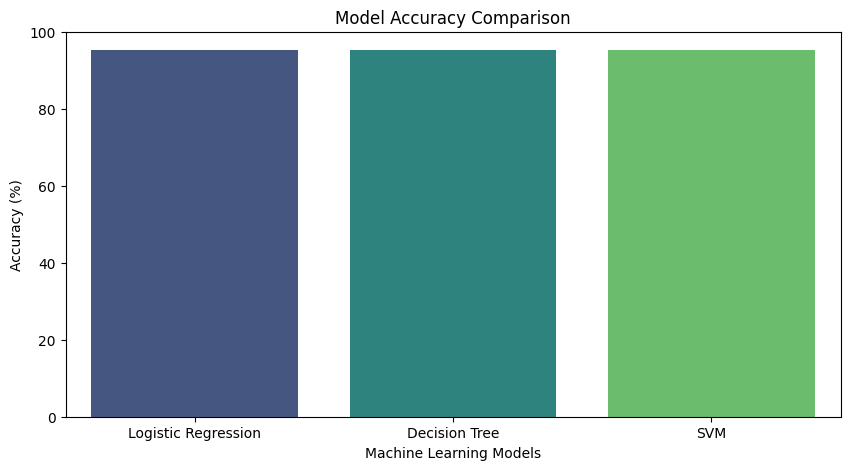

In [24]:
# --- Visualization Section ---
plt.figure(figsize=(10, 5))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.xlabel("Machine Learning Models")
plt.show()

In [25]:
# --- User Input ---
news_input = news

In [26]:
# --- Compare user input to GNews ---
user_vec = vectorizer.transform([news_input])
similarity_to_gnews = cosine_similarity(user_vec, gnews_vectors).max()

classification = "✅ REAL NEWS" if similarity_to_gnews >= 0.7 else "❌ FAKE NEWS"
print(f"\n🔍 COSINE SIMILARITY RESULT:")
print(f"Similarity with trusted GNews: {similarity_to_gnews * 100:.2f}%")


🔍 COSINE SIMILARITY RESULT:
Similarity with trusted GNews: 83.71%


In [27]:
# --- Model predictions for user input ---
user_vec_ml = vectorizer_ml.transform([news_input])

print("\n📊 ML Model Predictions:")
for name, model in models.items():
    pred = model.predict(user_vec_ml)[0]
    print(f"{name}: {'✅ REAL NEWS' if pred == 1 else '❌ FAKE NEWS'}")


📊 ML Model Predictions:
Logistic Regression: ❌ FAKE NEWS
Decision Tree: ✅ REAL NEWS
SVM: ❌ FAKE NEWS


In [28]:
# --- Display Related Twitter/Reddit Users spreading similar content ---
print("\n📢 Related Twitter Users spreading similar content:")
if not df_tweets.empty:
    similar_tweets = df_tweets[df_tweets['Label'] == 0].head(5)
    if not similar_tweets.empty:
        print(similar_tweets[['Author Name', 'Author Username', 'Author Verified',
                              'Likes', 'Retweets', 'Replies', 'Tweet URL', 'Max Similarity']].to_string(index=False))
    else:
        print("✅ No fake or mismatched tweets found.")
else:
    print("No Twitter data available.")

print("\n🧠 Related Reddit Users spreading similar content:")
if not df_reddit.empty:
    similar_reddit = df_reddit[df_reddit['Label'] == 0].head(5)
    if not similar_reddit.empty:
        print(similar_reddit[['Author', 'Subreddit', 'Score', 'Upvote Ratio (%)',
                              'Post URL', 'Max Similarity']].to_string(index=False))
    else:
        print("✅ No fake or mismatched Reddit posts found.")
else:
    print("No Reddit data available.")


📢 Related Twitter Users spreading similar content:
          Author Name Author Username  Author Verified  Likes  Retweets  Replies                                          Tweet URL  Max Similarity
Investment Guru India       InvGurInd            False      0         0        0 https://x.com/InvGurInd/status/1985297926248100127         0.43063

🧠 Related Reddit Users spreading similar content:
             Author            Subreddit  Score  Upvote Ratio (%)                                                                                                Post URL  Max Similarity
       GetGodmodeon   IndianMarketUpdate      1               100                   https://www.reddit.com/r/IndianMarketUpdate/comments/1oq33o4/market_brief_6_nov_2025/        0.017722
ParticularPlant8978              PE_Exam      0                50       https://www.reddit.com/r/PE_Exam/comments/1oq30fx/fe_pe_for_texas_board_nonus_education_question/        0.017996
   Pretend_Cup_4738     DarknessPrevails   

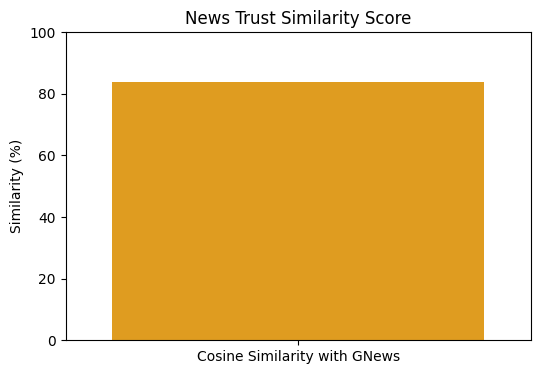

In [29]:
# --- Visualize Cosine Similarity ---
plt.figure(figsize=(6, 4))
sns.barplot(x=["Cosine Similarity with GNews"], y=[similarity_to_gnews * 100], color='orange')
plt.ylabel("Similarity (%)")
plt.title("News Trust Similarity Score")
plt.ylim(0, 100)
plt.show()


# Checking Trend of posting news

In [30]:
import pandas as pd
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine user-post data
df_tweets['Platform'] = 'Twitter'
df_reddit['Platform'] = 'Reddit'
df_all = pd.concat([
    df_tweets.rename(columns={'Author Username': 'Author', 'Tweet Text': 'Post'}),
    df_reddit.rename(columns={'Post Text': 'Post'})
])[['Author', 'Post', 'Label', 'Platform']].dropna()

# Encode users as numeric IDs
user_encoder = LabelEncoder()
df_all['UserID'] = user_encoder.fit_transform(df_all['Author'])

# TF-IDF vectorization for posts
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
post_embeddings = vectorizer.fit_transform(df_all['Post']).toarray()

# Compute post–post similarity
sim_matrix = cosine_similarity(post_embeddings)

# Create edges (if similarity > 0.5)
edges_post_post = []
for i in range(len(sim_matrix)):
    for j in range(i+1, len(sim_matrix)):
        if sim_matrix[i][j] > 0.5:
            edges_post_post.append([i, j])

# User → Post edges
edges_user_post = list(zip(df_all['UserID'], range(len(df_all))))

# Convert edges to PyTorch tensors
import torch
edge_index_user_post = torch.tensor(edges_user_post, dtype=torch.long).t().contiguous()
edge_index_post_post = torch.tensor(edges_post_post, dtype=torch.long).t().contiguous()

# Node features (for posts only)
x = torch.tensor(post_embeddings, dtype=torch.float)
y = torch.tensor(df_all['Label'].values, dtype=torch.long)

data = Data(x=x, edge_index=edge_index_post_post, y=y)
print(data)


Data(x=[89, 500], edge_index=[2, 30], y=[89])


In [31]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize and train
model = GCNClassifier(in_channels=x.shape[1], hidden_channels=64, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


Epoch 0: Loss = 0.7207
Epoch 10: Loss = 0.0075
Epoch 20: Loss = 0.0004
Epoch 30: Loss = 0.0003
Epoch 40: Loss = 0.0004
Epoch 50: Loss = 0.0005
Epoch 60: Loss = 0.0010
Epoch 70: Loss = 0.0013
Epoch 80: Loss = 0.0020
Epoch 90: Loss = 0.0015


In [32]:
model.eval()
with torch.no_grad():
    out = model(data)
    preds = out.argmax(dim=1)

# Accuracy
correct = (preds == data.y).sum().item()
acc = correct / len(data.y)
print(f"\n✅ GCN Accuracy: {acc*100:.2f}%")

# Add predictions back to dataframe
df_all['Predicted_Label'] = preds.cpu().numpy()



✅ GCN Accuracy: 100.00%


In [33]:
user_trend = (
    df_all.groupby('Author')['Predicted_Label']
    .mean()
    .reset_index()
    .rename(columns={'Predicted_Label': 'Fake_News_Ratio'})
)

# If Fake_News_Ratio ~ 1 → Mostly fake posts
# If Fake_News_Ratio ~ 0 → Mostly real posts
print("\n🚨 Users with higher fake-news ratio:")
print(user_trend.sort_values(by='Fake_News_Ratio', ascending=False).head(10))



🚨 Users with higher fake-news ratio:
                 Author  Fake_News_Ratio
0          5DollarALead              0.0
1  Agile_Specialist7478              0.0
2  Agitated_Locksmith27              0.0
3       AmbitionNew4393              0.0
4  Big-Maintenance-6870              0.0
5             Boogiegal              0.0
6  CartographerThat3431              0.0
7      Cheap-Shirt-1706              0.0
8       Coffee-Addict-1              0.0
9     Cultural_Care1866              0.0


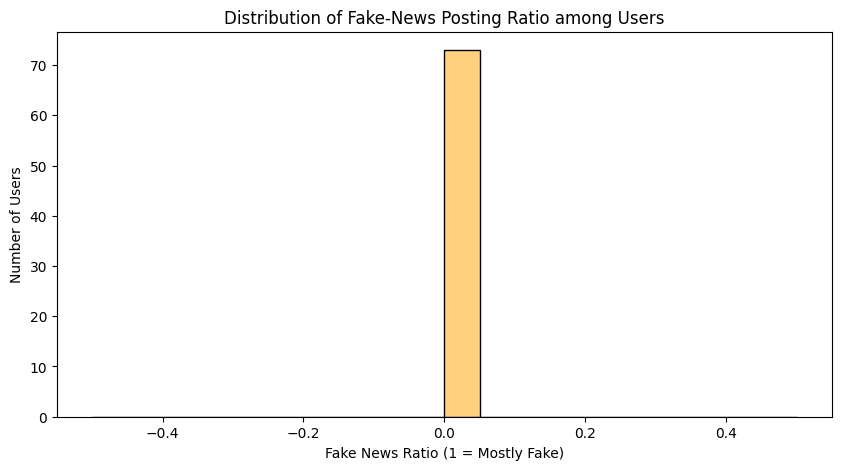

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(user_trend['Fake_News_Ratio'], bins=20, kde=True, color='orange')
plt.title("Distribution of Fake-News Posting Ratio among Users")
plt.xlabel("Fake News Ratio (1 = Mostly Fake)")
plt.ylabel("Number of Users")
plt.show()


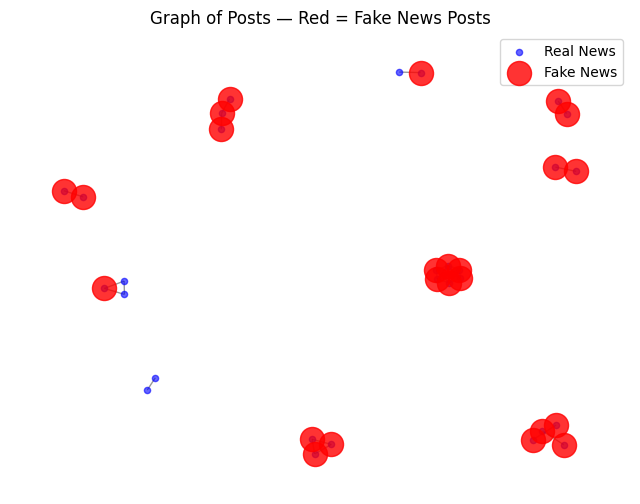

In [38]:
import matplotlib.pyplot as plt
import networkx as nx

# Create the graph
G = nx.Graph()
G.add_edges_from(edges_post_post)

# Fake news node indices (make sure they exist in G)
fake_nodes = [n for n in df_all[df_all['Predicted_Label'] == 0].index.tolist() if n in G.nodes()]

# Compute positions once
pos = nx.spring_layout(G, seed=42)

# Plot
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='blue', alpha=0.6, label='Real News')
nx.draw_networkx_nodes(G, pos, nodelist=fake_nodes, node_color='red', alpha=0.8, label='Fake News')
nx.draw_networkx_edges(G, pos, alpha=0.4)

plt.title("Graph of Posts — Red = Fake News Posts")
plt.legend(scatterpoints=1, fontsize=10)
plt.axis('off')
plt.show()


In [41]:
%%writefile app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

st.set_page_config(page_title="Fake News Detection", layout="wide")

st.title("🧠 Fake News Detection using GCN + ML Models")
st.write("Visualizing posts and relationships between Twitter and Reddit sources.")

st.sidebar.header("📂 Upload Data")
uploaded_file = st.sidebar.file_uploader("Upload a CSV file with posts", type=["csv"])

if uploaded_file:
    df = pd.read_csv(uploaded_file)
    st.subheader("📊 Uploaded Data Preview")
    st.dataframe(df.head())

    # Example visualization
    st.subheader("🌐 Graph Visualization")
    G = nx.Graph()
    for i in range(len(df)):
        G.add_node(i)
    nx.draw(G, with_labels=False, node_color='lightblue', alpha=0.6)
    st.pyplot(plt)

else:
    st.info("⬆️ Please upload a CSV dataset to visualize the graph.")

st.sidebar.markdown("---")
st.sidebar.write("Developed by **Kuheli Bera** 💻")


Writing app.py


In [42]:
!ls


app.py	gnews.csv  reddit.csv  sample_data  tweets.csv


In [45]:
!pip install pyngrok


In [46]:
# Start streamlit in background
get_ipython().system_raw('streamlit run app.py --server.port 8501 &')

from pyngrok import ngrok

# You can optionally set your ngrok authtoken first (recommended but optional).
# ngrok.set_auth_token("YOUR_NGROK_AUTH_TOKEN")  # optional

# Create a public http tunnel to port 8501 (no HTTP basic auth)
public_url = ngrok.connect(8501, "http")
print("Public URL:", public_url)


Public URL: NgrokTunnel: "https://savouriest-roxanne-botryose.ngrok-free.dev" -> "http://localhost:8501"
